In [1]:
%load_ext autoreload
%autoreload 2

# For general tuning after cuML analysis

In [2]:
import sys
sys.path.append('../')
import tokamakTK

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

In [4]:
# Low Multicollinearity
features = ['BETASTAR','BT','DWDIA','ENBI','HYBRID','IP','KAREA','LHTIME',
            'MEFF','NEL','NUSTAR','PECRH','PFLOSS','PICRH','PLTH','POHM','PRAD',
            'Q95','RHOSTAR','TAV','WFICFORM']


DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

In [5]:
X = data_.drop("label", axis=1)
y = data_["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_restarts_optimizer': [1, 5, 10, 20],
    'warm_start': [True, False],
    'max_iter_predict': [100, 150, 200]
}

rf = GaussianProcessClassifier(
                            random_state=71,
                            n_jobs=-1,
                           )

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=71), 
                           scoring='recall', 
                           n_jobs=1, 
                           refit=True
                          )

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model from the GridSearchCV
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

GaussianProcessClassifier(n_jobs=-1, n_restarts_optimizer=1, random_state=71,
                          warm_start=True)

In [6]:
# Make predictions on the test set
y_pred = best_model.predict_proba(X_val)

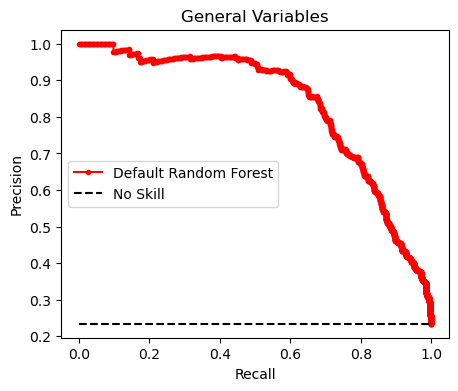

In [7]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("General Variables")
plt.legend();

In [8]:
y_pred_ = best_model.predict(X_val)
precision_recall_fscore_support(y_val, y_pred_, labels=[1,0])

(array([0.83798883, 0.90777339]),
 array([0.68181818, 0.95961003]),
 array([0.7518797 , 0.93297224]),
 array([ 440, 1436]))

In [9]:
best_params

{'max_iter_predict': 100, 'n_restarts_optimizer': 1, 'warm_start': True}